<a href="https://colab.research.google.com/github/Nniichha/229352-StatisticalLearning/blob/main/660510739_Lab02_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [ ]:
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [ ]:
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
age               0
job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64


In [ ]:
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

--- Unique Values for Categorical Columns ---

'job' unique values:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

'marital' unique values:
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

'education' unique values:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

'default' unique values:
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

'housing' unique values:
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64


### Data Preprocessing

In [ ]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})


# Drop 'duration' due to data leakage
df = df.drop('duration', axis=1)


# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']


# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Print data shape
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (32950, 14)
X_test shape: (8238, 14)
y_train shape: (32950,)
y_test shape: (8238,)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [ ]:
num_cols_demo = ['age', 'campaign']

scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[num_cols_demo])

StandardScaler()

**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [ ]:
ord_col_demo = ['education']

imputer_ord = SimpleImputer(strategy='most_frequent')

# Fit the imputer ONLY on the training data
imputer_ord.fit(X_train[ord_col_demo])

X_train_imputed_ord_demo = imputer_ord.transform(X_train[ord_col_demo])
X_test_imputed_ord_demo = imputer_ord.transform(X_test[ord_col_demo])

- **Ordinal Encoding**

In [ ]:
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [ ]:
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

X_train_encoded_ord_demo = ordinal_encoder.fit_transform(X_train_imputed_ord_demo)
X_test_encoded_ord_demo = ordinal_encoder.transform(X_test_imputed_ord_demo)

**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [ ]:
nom_col_demo = ['job']

imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo])

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [ ]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_encoded_nom_demo = onehot_encoder.fit_transform(X_train_imputed_nom_demo)
X_test_encoded_nom_demo = onehot_encoder.transform(X_test_imputed_nom_demo)

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [ ]:
# --- YOUR CODE FOR EXERCISE 1 STARTS HERE ---

# 1. Define feature lists
numerical_features = ['age', 'campaign', 'pdays', 'previous']
ordinal_features = ['education']
# Exclude 'duration' as it's already dropped
nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# 2. Make copies of X_train and X_test
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# Preprocessing Pipelines

# Numerical Features: Standard Scaling
scaler_full = StandardScaler()
X_train_scaled_num = scaler_full.fit_transform(X_train_copy[numerical_features])
X_test_scaled_num = scaler_full.transform(X_test_copy[numerical_features])

# Ordinal Features: Imputation + Ordinal Encoding
imputer_ord_full = SimpleImputer(strategy='most_frequent')
X_train_imputed_ord = imputer_ord_full.fit_transform(X_train_copy[ordinal_features])
X_test_imputed_ord = imputer_ord_full.transform(X_test_copy[ordinal_features])

ordinal_encoder_full = OrdinalEncoder(categories=[education_categories], handle_unknown='use_encoded_value', unknown_value=-1)
X_train_encoded_ord = ordinal_encoder_full.fit_transform(X_train_imputed_ord)
X_test_encoded_ord = ordinal_encoder_full.transform(X_test_imputed_ord)

# Nominal Features: Imputation + One-Hot Encoding
imputer_nom_full = SimpleImputer(strategy='most_frequent')
X_train_imputed_nom = imputer_nom_full.fit_transform(X_train_copy[nominal_features])
X_test_imputed_nom = imputer_nom_full.transform(X_test_copy[nominal_features])

onehot_encoder_full = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded_nom = onehot_encoder_full.fit_transform(X_train_imputed_nom)
X_test_encoded_nom = onehot_encoder_full.transform(X_test_imputed_nom)

# Combine all processed features
# Get feature names for one-hot encoded nominal features
onehot_feature_names = onehot_encoder_full.get_feature_names_out(nominal_features)

X_train_processed_df = pd.DataFrame(X_train_scaled_num, columns=numerical_features)
X_train_processed_df[ordinal_features[0]] = X_train_encoded_ord
X_train_processed_df = pd.concat([X_train_processed_df, pd.DataFrame(X_train_encoded_nom, columns=onehot_feature_names)], axis=1)

X_test_processed_df = pd.DataFrame(X_test_scaled_num, columns=numerical_features)
X_test_processed_df[ordinal_features[0]] = X_test_encoded_ord
X_test_processed_df = pd.concat([X_test_processed_df, pd.DataFrame(X_test_encoded_nom, columns=onehot_feature_names)], axis=1)


# Train Logistic Regression
logistic_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
logistic_model.fit(X_train_processed_df, y_train)

# Evaluate the Model
y_pred = logistic_model.predict(X_test_processed_df)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.70      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.80      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [ ]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [ ]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

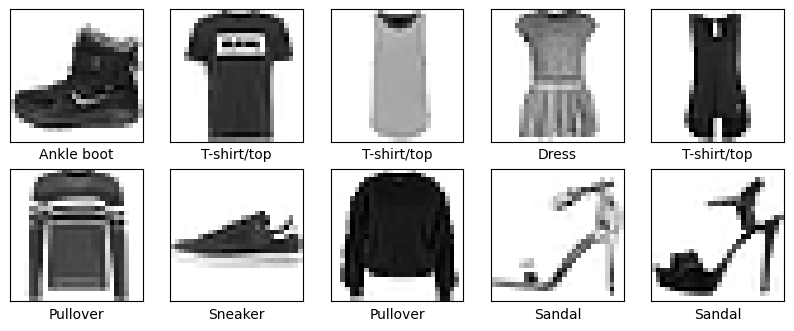

In [ ]:
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1) # Adjust subplot grid to show more images if needed
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fm_X_train[i], cmap=plt.cm.binary)
    plt.xlabel(fashion_mnist_class_names[fm_y_train[i]])
plt.show()

### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

In [ ]:
# --- YOUR CODE FOR EXERCISE 2 STARTS HERE ---

# 1. Flatten and Scale
fm_X_train_scaled = fm_X_train.reshape(fm_X_train.shape[0], -1) / 255.0
fm_X_test_scaled = fm_X_test.reshape(fm_X_test.shape[0], -1) / 255.0

print(f"Flattened & Scaled fm_X_train shape: {fm_X_train_scaled.shape}")
print(f"Flattened & Scaled fm_X_test shape: {fm_X_test_scaled.shape}")

# 3. Train Logistic Regression
logistic_model_fm = LogisticRegression(solver='saga', random_state=42, max_iter=1000, n_jobs=-1) # n_jobs=-1 uses all available cores
logistic_model_fm.fit(fm_X_train_scaled, fm_y_train)

# 4. Make Predictions
fm_y_pred = logistic_model_fm.predict(fm_X_test_scaled)

# 5. Print Classification Report
print("\n--- Fashion-MNIST Classification Report ---")
print(classification_report(fm_y_test, fm_y_pred, target_names=fashion_mnist_class_names))

# 6. Visualize Misclassifications
incorrect_indices = np.where(fm_y_pred != fm_y_test)[0]

# Select up to 5 random misclassified images
num_misclassified_to_show = min(5, len(incorrect_indices))
np.random.seed(42) # for reproducibility
sample_incorrect_indices = np.random.choice(incorrect_indices, num_misclassified_to_show, replace=False)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(sample_incorrect_indices):
    plt.subplot(1, num_misclassified_to_show, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fm_X_test[idx], cmap=plt.cm.binary)
    true_label = fashion_mnist_class_names[fm_y_test[idx]]
    predicted_label = fashion_mnist_class_names[fm_y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
plt.suptitle("Misclassified Fashion-MNIST Images")
plt.tight_layout()
plt.show()

Flattened & Scaled fm_X_train shape: (60000, 784)
Flattened & Scaled fm_X_test shape: (10000, 784)


## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [ ]:
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

### Explore Sample Document

In [ ]:
# Print the first document and its class
print(f"Document:\n{X_train_news[0]}\n")
print(f"Class: {news_train.target_names[y_train_news[0]]}")

### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [ ]:
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

sample_vec_output_dense = sample_vec_output_sparse.toarray()

print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())
print(sample_vec_output_dense)

### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [ ]:
# --- YOUR CODE FOR EXERCISE 3 STARTS HERE ---

# 1. Initialize TfidfVectorizer
vectorizer_full = TfidfVectorizer(stop_words='english')

# 2. Fit and Transform Training Data
X_train_vec = vectorizer_full.fit_transform(X_train_news)

# 3. Transform Test Data
X_test_vec = vectorizer_full.transform(X_test_news)

print(f"Shape of X_train_vec: {X_train_vec.shape}")
print(f"Shape of X_test_vec: {X_test_vec.shape}")

# 4. Initialize Logistic Regression
logistic_model_news = LogisticRegression(solver='saga', random_state=42, max_iter=1000, n_jobs=-1)

# 5. Train the Model
logistic_model_news.fit(X_train_vec, y_train_news)

# 6. Make Predictions
y_pred_news = logistic_model_news.predict(X_test_vec)

# 7. Evaluate the Model
print("\n--- 20 Newsgroups Classification Report ---")
print(classification_report(y_test_news, y_pred_news, target_names=news_train.target_names))